In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#  Step 1: File ka naam (agar aap ne same naam se upload ki hai)
file_path = "5 STOCK DATA.xlsx"

# Step 2: Excel file read karo
df = pd.read_excel(file_path)

#  Step 3: DATE column ko index banao (agar date wali column hai)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

#  Step 4: Column names clean karo (extra spaces remove)
df.columns = [col.strip() for col in df.columns]

# 📌 Step 5: Sirf returns ka data rakh lo
returns = df.copy()

#  Step 6: Data dekh lo
print("✅ Returns Data Loaded Successfully!\n")
print(returns.head())


✅ Returns Data Loaded Successfully!

           NATIONAL FOODS RETURNS PSO RETURNS SYSTEMS LIMITED RETURNS  \
DATE                                                                    
2021-06-09                      -           -                       -   
2021-06-10               0.005956    0.003298                0.026017   
2021-06-11               0.009718    0.000822                0.007524   
2021-06-14               0.006267   -0.004926                0.045793   
2021-06-15              -0.005383    0.011551                -0.01787   

           PPL RETURNS FFC RETURNS  
DATE                                
2021-06-09           -           -  
2021-06-10    0.003105    0.010325  
2021-06-11    0.008597    0.010787  
2021-06-14   -0.002387    -0.01554  
2021-06-15    0.001367    0.010175  


In [2]:
# Replace "-" with NaN and drop rows
returns = returns.replace("-", None).dropna()
returns = returns.astype(float)

print("\nAfter Cleaning:\n")
print(returns.head())


After Cleaning:

            NATIONAL FOODS RETURNS  PSO RETURNS  SYSTEMS LIMITED RETURNS  \
DATE                                                                       
2021-06-10                0.005956     0.003298                 0.026017   
2021-06-11                0.009718     0.000822                 0.007524   
2021-06-14                0.006267    -0.004926                 0.045793   
2021-06-15               -0.005383     0.011551                -0.017870   
2021-06-16                0.008051    -0.008972                 0.003385   

            PPL RETURNS  FFC RETURNS  
DATE                                  
2021-06-10     0.003105     0.010325  
2021-06-11     0.008597     0.010787  
2021-06-14    -0.002387    -0.015540  
2021-06-15     0.001367     0.010175  
2021-06-16    -0.021160     0.003671  


In [3]:
# Average return of each stock
mean_returns = returns.mean()

# Covariance matrix shows relation of risks between stocks
cov_matrix = returns.cov()

print("\n Average (Mean) Returns:\n", mean_returns)
print("\n Covariance Matrix (Risk):\n", cov_matrix)


 Average (Mean) Returns:
 NATIONAL FOODS RETURNS     0.000176
PSO RETURNS                0.000304
SYSTEMS LIMITED RETURNS    0.001010
PPL RETURNS                0.000193
FFC RETURNS                0.000986
dtype: float64

 Covariance Matrix (Risk):
                          NATIONAL FOODS RETURNS   PSO RETURNS  \
NATIONAL FOODS RETURNS             2.868541e-04  2.323661e-07   
PSO RETURNS                        2.323661e-07  4.070740e-04   
SYSTEMS LIMITED RETURNS            8.776086e-05  1.882901e-05   
PPL RETURNS                        1.129745e-06  5.089771e-05   
FFC RETURNS                        3.909158e-05  4.975163e-08   

                         SYSTEMS LIMITED RETURNS   PPL RETURNS   FFC RETURNS  
NATIONAL FOODS RETURNS                  0.000088  1.129745e-06  3.909158e-05  
PSO RETURNS                             0.000019  5.089771e-05  4.975163e-08  
SYSTEMS LIMITED RETURNS                 0.000386  1.164959e-05  5.436880e-05  
PPL RETURNS                             0.

In [6]:
#Risk-Free Rate
rf_annual = 0.08   # 8% risk-free
trading_days = 252
rf_daily = (1 + rf_annual)**(1/trading_days) - 1

print("Step 4  Risk-Free Rate Set!")
print("-> Annual RF:", rf_annual)
print("-> Daily RF:", rf_daily)

Step 4  Risk-Free Rate Set!
-> Annual RF: 0.08
-> Daily RF: 0.00030544759650941167


In [7]:
#Portfolio Functions
def portfolio_return(weights):
    return np.dot(weights, mean_returns) * trading_days

def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(trading_days)

def sharpe_ratio(weights):
    return (portfolio_return(weights) - rf_annual) / portfolio_volatility(weights)

print("Functions Defined!")

Functions Defined!


In [9]:
#Optimize for Max Sharpe
from scipy.optimize import minimize
num_assets = len(mean_returns)
bounds = tuple((0,1) for _ in range(num_assets))
constraints = {'type':'eq', 'fun': lambda x: np.sum(x) - 1}
init_guess = num_assets * [1./num_assets]

def neg_sharpe(weights):
    return -sharpe_ratio(weights)

opt_result = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = opt_result.x

print("Optimization Done!")
print("-> Success:", opt_result.success)
print("-> Optimal Weights (fractions):", optimal_weights)
print("-> Optimal Weights (%):", optimal_weights * 100)

Optimization Done!
-> Success: True
-> Optimal Weights (fractions): [2.46701831e-16 0.00000000e+00 1.80625798e-01 0.00000000e+00
 8.19374202e-01]
-> Optimal Weights (%): [2.46701831e-14 0.00000000e+00 1.80625798e+01 0.00000000e+00
 8.19374202e+01]


In [10]:
#Portfolio Stats
best_return = portfolio_return(optimal_weights)
best_volatility = portfolio_volatility(optimal_weights)
best_sharpe = sharpe_ratio(optimal_weights)

print(" Best Portfolio Stats:")
print("-> Expected Annual Return:", best_return)
print("-> Annual Volatility:", best_volatility)
print("-> Sharpe Ratio:", best_sharpe)

 Best Portfolio Stats:
-> Expected Annual Return: 0.2495154603838005
-> Annual Volatility: 0.16743435474938145
-> Sharpe Ratio: 1.012429382473711


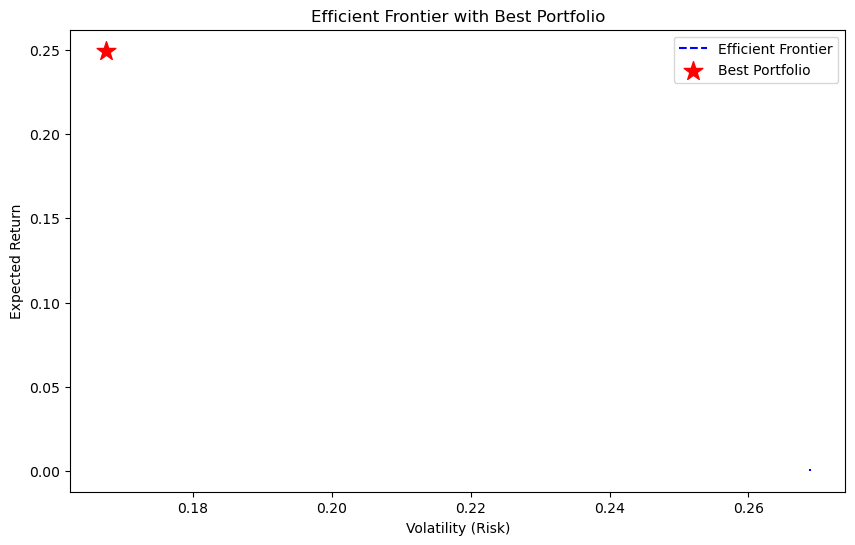

In [12]:
#Efficient Frontier Graph
import matplotlib.pyplot as plt

# Efficient frontier (different target returns)
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
target_vols = []

for r in target_returns:
    constraints_rf = (
        {'type':'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type':'eq', 'fun': lambda x: portfolio_return(x) - r}
    )
    frontier = minimize(portfolio_volatility, init_guess, 
                        method='SLSQP', bounds=bounds, constraints=constraints_rf)
    target_vols.append(frontier.fun)

plt.figure(figsize=(10,6))

# Efficient Frontier curve
plt.plot(target_vols, target_returns, 'b--', label='Efficient Frontier')

# Best Portfolio point
plt.scatter(best_volatility, best_return, c='red', marker='*', s=200, label='Best Portfolio')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with Best Portfolio")
plt.legend()
plt.show()

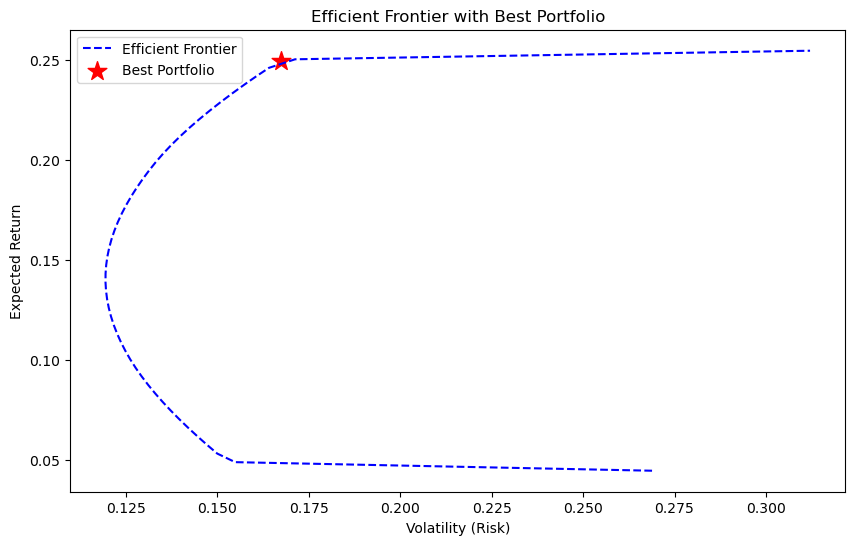

In [14]:
target_returns = np.linspace(mean_returns.min()*252, mean_returns.max()*252, 50)
target_vols = []

for r in target_returns:
    constraints_rf = (
        {'type':'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type':'eq', 'fun': lambda x, r=r: portfolio_return(x) - r}
    )
    frontier = minimize(portfolio_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=constraints_rf)
    if frontier.success:
        target_vols.append(frontier.fun)
    else:
        target_vols.append(np.nan)

# Clean NaNs
vols_clean = np.array(target_vols)
rets_clean = np.array(target_returns)
mask = ~np.isnan(vols_clean)

plt.figure(figsize=(10,6))
plt.plot(vols_clean[mask], rets_clean[mask], 'b--', label="Efficient Frontier")
plt.scatter(best_volatility, best_return, c='red', marker='*', s=200, label="Best Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier with Best Portfolio")
plt.legend()
plt.show()

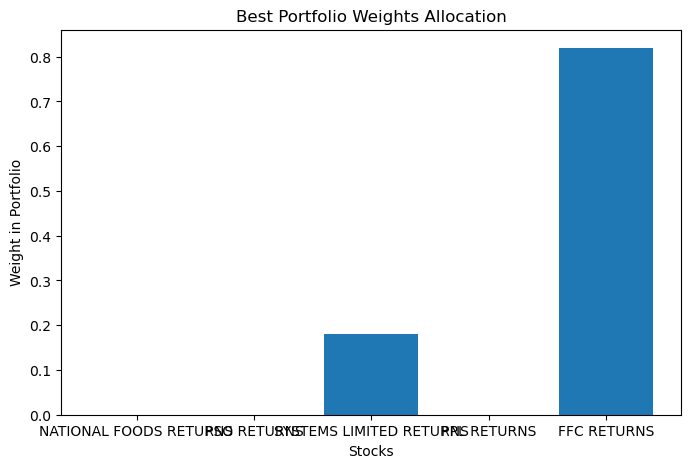

In [15]:
plt.figure(figsize=(8,5))
plt.bar(returns.columns, optimal_weights)
plt.title("Best Portfolio Weights Allocation")
plt.xlabel("Stocks")
plt.ylabel("Weight in Portfolio")
plt.show()

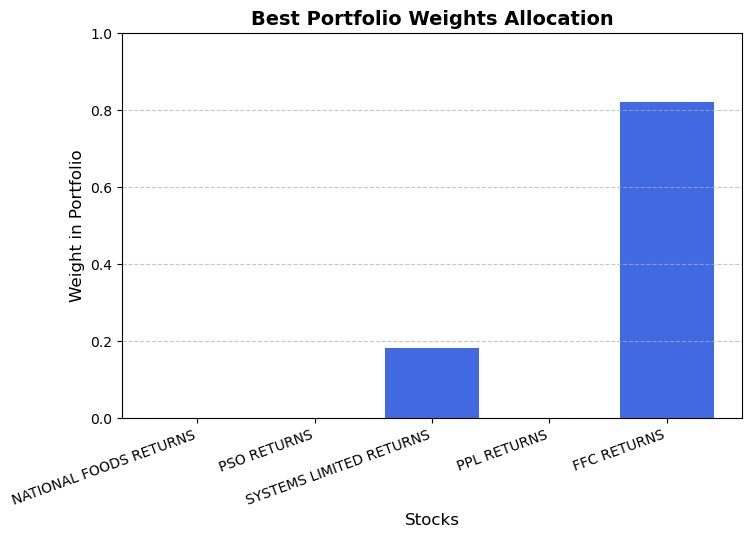

In [16]:
plt.figure(figsize=(8,5))
plt.bar(df.columns, optimal_weights, color="royalblue")
plt.title("Best Portfolio Weights Allocation", fontsize=14, fontweight="bold")
plt.xlabel("Stocks", fontsize=12)
plt.ylabel("Weight in Portfolio", fontsize=12)
plt.xticks(rotation=20, ha="right")   # tilt labels so overlap na ho
plt.ylim(0,1)                         # y-axis 0 se 1 tak
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()